In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold

In [3]:
filename = '../../data/similarity/triplet-data.csv'
df = pd.read_csv(filename)
# Flatten all unique entries from the DataFrame
unique_entries = pd.unique(df.values.ravel())
# move NaNs to the end
unique_entries = np.append(unique_entries[~pd.isna(unique_entries)], unique_entries[pd.isna(unique_entries)])
# Map each unique entry to a unique ID starting from 0
item_to_id_map = {entry: idx for idx, entry in enumerate(unique_entries)}
num_items = len(item_to_id_map)
item_to_id_map
# apply the mapping to the DataFrame
simple_df = df.map(lambda x: item_to_id_map[x])
simple_df[:20]

,reference,selected,rest
0,0,1,2
1,0,1,3
2,0,1,4
3,0,1,5
4,0,1,6
5,0,1,7
6,0,1,8
7,0,1,9
8,0,1,10
9,0,1,11


In [4]:
# # go through df and identify those triplets (i,j,k) which 
# # appear multiple times or
# # both (i,j,k) and (i,k,j) appear
# # separate out all such triplets into a separate DataFrame and remove them from the original DataFrame

# # create a column called options where each entry is a tuple of the last two entries, with the smaller entry first
# simple_df['options'] = simple_df.apply(lambda x: tuple(sorted(x[-2:])), axis=1)

# # create a new dataframe with only the reference and options columns
# base_df = simple_df[['reference', 'options']]

# # create a new DataFrame with the triplets that appear multiple times
# duplicates_df = simple_df[base_df.duplicated(keep=False)]

# # sort duplicates_df by the reference column and then the options column
# # this is just for visualization purposes
# # duplicates_df = duplicates_df.sort_values(by=['reference', 'options'])
# # duplicates_df[:30]
# # create a new DataFrame called unique_df which contains only the unique triplets
# # i.e. those triplets which do not appear in duplicates_df
# unique_df = simple_df[~base_df.duplicated(keep=False)]
# assert len(unique_df) + len(duplicates_df) == len(simple_df)

In [5]:
# go through df and identify those triplets (i,j,k) which appear multiple times 
# separate out all such triplets into a separate DataFrame and remove them from the original DataFrame

# create a new DataFrame with the triplets that appear multiple times
simple_df = simple_df[~simple_df.duplicated()]

In [6]:
len(simple_df)

190376

In [7]:
# create a similar dataset as above by readin data from the file data/similarity/triplet-data.csv
class TripletDataset(Dataset):
    def __init__(self, df):
        self.samples = []
        
        for n in range(len(df)):
            i = df.iloc[n, 0]
            j = df.iloc[n, 1]
            k = df.iloc[n, 2]
            y = 1
            # convert (i,j,k,y) to tensors
            self.samples.append((torch.tensor(i), torch.tensor(j), torch.tensor(k), torch.tensor(y)))
            # self.samples.append((i, j, k, y))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [8]:
dataset = TripletDataset(simple_df)

In [9]:
class LowRankComparisonModel(nn.Module):
    def __init__(self, n, r):
        super(LowRankComparisonModel, self).__init__()
        self.X = nn.Parameter(torch.randn(n, r))  # Learnable matrix X
    
    def forward(self, i, j, k):
        Z_ij = (self.X[i] * self.X[j]).sum(dim=1)  # Z_{i,j}
        Z_ik = (self.X[i] * self.X[k]).sum(dim=1)  # Z_{i,k}
        return torch.sigmoid(Z_ij - Z_ik)

In [10]:
# take the training code and accuracy computation code and put them in a function

def train_model(model, criterion, optimizer, dataloader, validation_loader, num_epochs=100):
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    for epoch in range(num_epochs):
        total_loss = 0
        for i, j, k, y in dataloader:
            i = i.long()
            j = j.long()
            k = k.long()
            y = y.float()
            
            predictions = model(i, j, k)
            loss = criterion(predictions, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        train_losses.append(total_loss/len(dataloader))
        with torch.no_grad():
            val_loss = 0
            for i, j, k, y in validation_loader:
                i = i.long()
                j = j.long()
                k = k.long()
                y = y.float()
                predictions = model(i, j, k)
                val_loss += criterion(predictions, y).item()
            valid_losses.append(val_loss/len(validation_loader))
            if val_loss < best_valid_loss - 0.0001:
                best_valid_loss = val_loss
            else:
                break
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')
    return train_losses, valid_losses

In [11]:
def compute_accuracy(model, validation_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for i, j, k, y in validation_loader:
            i = i.long()
            j = j.long()
            k = k.long()
            y = y.float()
            predictions = model(i, j, k)
            predicted = torch.round(predictions)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    print(f'Accuracy of the model on the {total} validation samples: {100 * correct / total}%')
    return 100 * correct / total


Fold 1/5

 Rank: 2 computation started for Fold 1

Epoch [1/100], Loss: 0.9001, Validation Loss: 0.8219
Epoch [2/100], Loss: 0.7833, Validation Loss: 0.7476
Epoch [3/100], Loss: 0.7262, Validation Loss: 0.7046
Epoch [4/100], Loss: 0.6872, Validation Loss: 0.6686
Epoch [5/100], Loss: 0.6490, Validation Loss: 0.6284
Epoch [6/100], Loss: 0.6051, Validation Loss: 0.5821
Epoch [7/100], Loss: 0.5577, Validation Loss: 0.5359
Epoch [8/100], Loss: 0.5149, Validation Loss: 0.4981
Epoch [9/100], Loss: 0.4825, Validation Loss: 0.4714
Epoch [10/100], Loss: 0.4604, Validation Loss: 0.4534
Epoch [11/100], Loss: 0.4456, Validation Loss: 0.4413
Epoch [12/100], Loss: 0.4354, Validation Loss: 0.4328
Epoch [13/100], Loss: 0.4280, Validation Loss: 0.4265
Epoch [14/100], Loss: 0.4226, Validation Loss: 0.4218
Epoch [15/100], Loss: 0.4183, Validation Loss: 0.4182
Epoch [16/100], Loss: 0.4150, Validation Loss: 0.4153
Epoch [17/100], Loss: 0.4124, Validation Loss: 0.4131
Epoch [18/100], Loss: 0.4102, Validatio

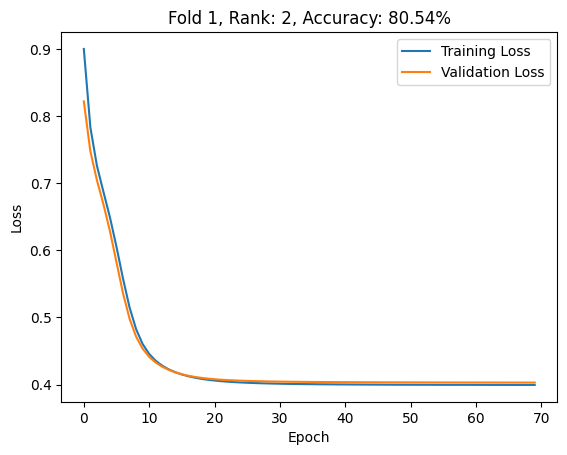


 Rank: 5 computation started for Fold 1

Epoch [1/100], Loss: 1.1880, Validation Loss: 1.0235
Epoch [2/100], Loss: 0.9251, Validation Loss: 0.8309
Epoch [3/100], Loss: 0.7678, Validation Loss: 0.7052
Epoch [4/100], Loss: 0.6592, Validation Loss: 0.6141
Epoch [5/100], Loss: 0.5803, Validation Loss: 0.5488
Epoch [6/100], Loss: 0.5253, Validation Loss: 0.5048
Epoch [7/100], Loss: 0.4891, Validation Loss: 0.4765
Epoch [8/100], Loss: 0.4655, Validation Loss: 0.4581
Epoch [9/100], Loss: 0.4498, Validation Loss: 0.4456
Epoch [10/100], Loss: 0.4388, Validation Loss: 0.4366
Epoch [11/100], Loss: 0.4305, Validation Loss: 0.4297
Epoch [12/100], Loss: 0.4240, Validation Loss: 0.4243
Epoch [13/100], Loss: 0.4188, Validation Loss: 0.4198
Epoch [14/100], Loss: 0.4144, Validation Loss: 0.4160
Epoch [15/100], Loss: 0.4107, Validation Loss: 0.4128
Epoch [16/100], Loss: 0.4075, Validation Loss: 0.4100
Epoch [17/100], Loss: 0.4048, Validation Loss: 0.4076
Epoch [18/100], Loss: 0.4025, Validation Loss: 0.

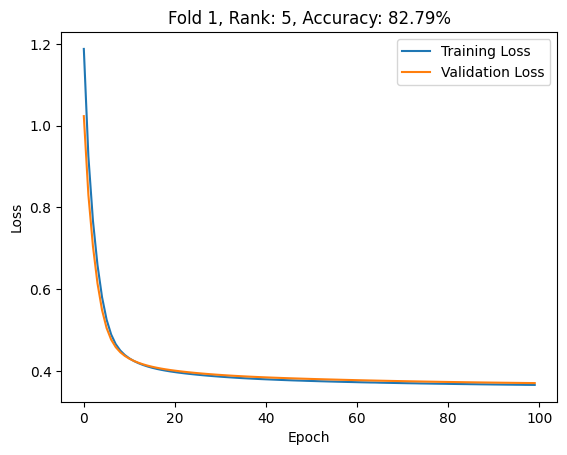


 Rank: 10 computation started for Fold 1

Epoch [1/100], Loss: 1.6001, Validation Loss: 1.3829
Epoch [2/100], Loss: 1.2074, Validation Loss: 1.0631
Epoch [3/100], Loss: 0.9380, Validation Loss: 0.8384
Epoch [4/100], Loss: 0.7497, Validation Loss: 0.6849
Epoch [5/100], Loss: 0.6266, Validation Loss: 0.5894
Epoch [6/100], Loss: 0.5524, Validation Loss: 0.5333
Epoch [7/100], Loss: 0.5087, Validation Loss: 0.4995
Epoch [8/100], Loss: 0.4814, Validation Loss: 0.4775
Epoch [9/100], Loss: 0.4631, Validation Loss: 0.4621
Epoch [10/100], Loss: 0.4497, Validation Loss: 0.4505
Epoch [11/100], Loss: 0.4392, Validation Loss: 0.4412
Epoch [12/100], Loss: 0.4308, Validation Loss: 0.4335
Epoch [13/100], Loss: 0.4236, Validation Loss: 0.4270
Epoch [14/100], Loss: 0.4175, Validation Loss: 0.4214
Epoch [15/100], Loss: 0.4121, Validation Loss: 0.4164
Epoch [16/100], Loss: 0.4073, Validation Loss: 0.4120
Epoch [17/100], Loss: 0.4030, Validation Loss: 0.4081
Epoch [18/100], Loss: 0.3992, Validation Loss: 0

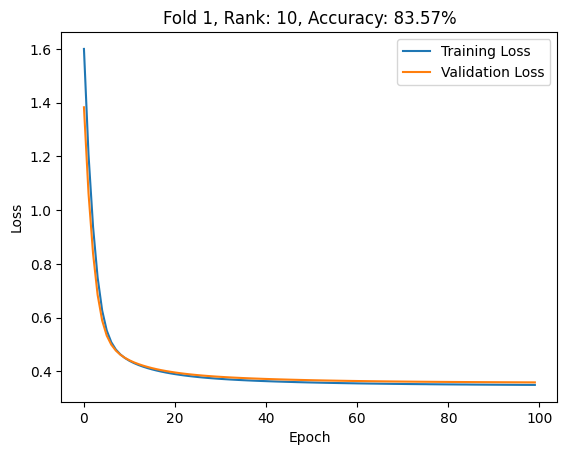


 Rank: 20 computation started for Fold 1

Epoch [1/100], Loss: 2.2390, Validation Loss: 1.9059
Epoch [2/100], Loss: 1.6623, Validation Loss: 1.4306
Epoch [3/100], Loss: 1.2441, Validation Loss: 1.0818
Epoch [4/100], Loss: 0.9461, Validation Loss: 0.8420
Epoch [5/100], Loss: 0.7525, Validation Loss: 0.6938
Epoch [6/100], Loss: 0.6363, Validation Loss: 0.6057
Epoch [7/100], Loss: 0.5663, Validation Loss: 0.5513
Epoch [8/100], Loss: 0.5215, Validation Loss: 0.5151
Epoch [9/100], Loss: 0.4905, Validation Loss: 0.4894
Epoch [10/100], Loss: 0.4679, Validation Loss: 0.4701
Epoch [11/100], Loss: 0.4505, Validation Loss: 0.4550
Epoch [12/100], Loss: 0.4367, Validation Loss: 0.4429
Epoch [13/100], Loss: 0.4255, Validation Loss: 0.4330
Epoch [14/100], Loss: 0.4162, Validation Loss: 0.4248
Epoch [15/100], Loss: 0.4085, Validation Loss: 0.4177
Epoch [16/100], Loss: 0.4019, Validation Loss: 0.4117
Epoch [17/100], Loss: 0.3962, Validation Loss: 0.4065
Epoch [18/100], Loss: 0.3913, Validation Loss: 0

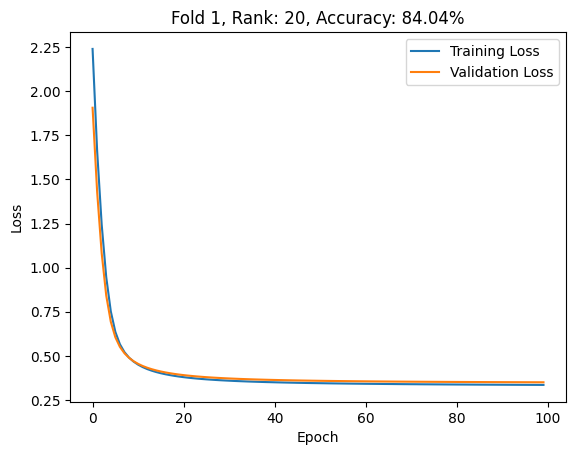


 Rank: 30 computation started for Fold 1

Epoch [1/100], Loss: 2.6515, Validation Loss: 2.2374
Epoch [2/100], Loss: 1.8778, Validation Loss: 1.5990
Epoch [3/100], Loss: 1.3591, Validation Loss: 1.1991
Epoch [4/100], Loss: 1.0508, Validation Loss: 0.9694
Epoch [5/100], Loss: 0.8721, Validation Loss: 0.8324
Epoch [6/100], Loss: 0.7605, Validation Loss: 0.7430
Epoch [7/100], Loss: 0.6843, Validation Loss: 0.6794
Epoch [8/100], Loss: 0.6285, Validation Loss: 0.6315
Epoch [9/100], Loss: 0.5856, Validation Loss: 0.5939
Epoch [10/100], Loss: 0.5517, Validation Loss: 0.5637
Epoch [11/100], Loss: 0.5244, Validation Loss: 0.5388
Epoch [12/100], Loss: 0.5017, Validation Loss: 0.5180
Epoch [13/100], Loss: 0.4829, Validation Loss: 0.5003
Epoch [14/100], Loss: 0.4668, Validation Loss: 0.4853
Epoch [15/100], Loss: 0.4531, Validation Loss: 0.4723
Epoch [16/100], Loss: 0.4413, Validation Loss: 0.4610
Epoch [17/100], Loss: 0.4311, Validation Loss: 0.4511
Epoch [18/100], Loss: 0.4222, Validation Loss: 0

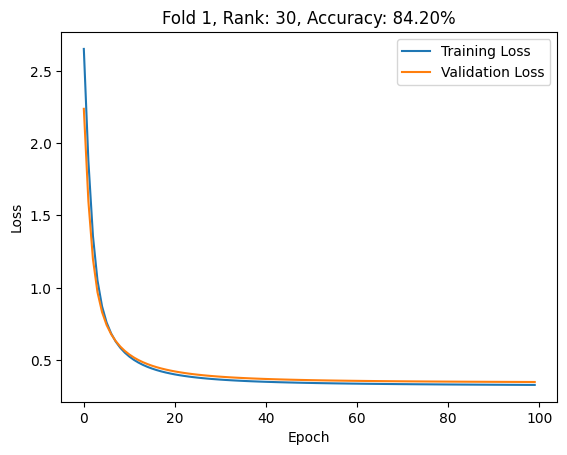


 Rank: 50 computation started for Fold 1

Epoch [1/100], Loss: 3.3030, Validation Loss: 2.7706
Epoch [2/100], Loss: 2.2835, Validation Loss: 1.9595
Epoch [3/100], Loss: 1.6583, Validation Loss: 1.4972
Epoch [4/100], Loss: 1.3077, Validation Loss: 1.2359
Epoch [5/100], Loss: 1.0999, Validation Loss: 1.0713
Epoch [6/100], Loss: 0.9626, Validation Loss: 0.9568
Epoch [7/100], Loss: 0.8641, Validation Loss: 0.8715
Epoch [8/100], Loss: 0.7894, Validation Loss: 0.8052
Epoch [9/100], Loss: 0.7306, Validation Loss: 0.7519
Epoch [10/100], Loss: 0.6829, Validation Loss: 0.7080
Epoch [11/100], Loss: 0.6433, Validation Loss: 0.6713
Epoch [12/100], Loss: 0.6100, Validation Loss: 0.6401
Epoch [13/100], Loss: 0.5817, Validation Loss: 0.6132
Epoch [14/100], Loss: 0.5572, Validation Loss: 0.5899
Epoch [15/100], Loss: 0.5360, Validation Loss: 0.5695
Epoch [16/100], Loss: 0.5173, Validation Loss: 0.5516
Epoch [17/100], Loss: 0.5008, Validation Loss: 0.5356
Epoch [18/100], Loss: 0.4862, Validation Loss: 0

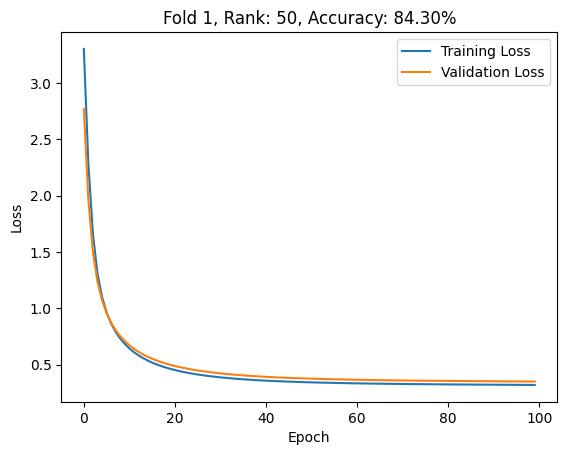


 Rank: 75 computation started for Fold 1

Epoch [1/100], Loss: 4.2664, Validation Loss: 3.6327
Epoch [2/100], Loss: 2.9549, Validation Loss: 2.5349
Epoch [3/100], Loss: 2.0689, Validation Loss: 1.8673
Epoch [4/100], Loss: 1.5654, Validation Loss: 1.4975
Epoch [5/100], Loss: 1.2822, Validation Loss: 1.2760
Epoch [6/100], Loss: 1.1041, Validation Loss: 1.1269
Epoch [7/100], Loss: 0.9804, Validation Loss: 1.0180
Epoch [8/100], Loss: 0.8880, Validation Loss: 0.9342
Epoch [9/100], Loss: 0.8161, Validation Loss: 0.8672
Epoch [10/100], Loss: 0.7580, Validation Loss: 0.8122
Epoch [11/100], Loss: 0.7100, Validation Loss: 0.7661
Epoch [12/100], Loss: 0.6698, Validation Loss: 0.7270
Epoch [13/100], Loss: 0.6354, Validation Loss: 0.6934
Epoch [14/100], Loss: 0.6057, Validation Loss: 0.6642
Epoch [15/100], Loss: 0.5798, Validation Loss: 0.6387
Epoch [16/100], Loss: 0.5572, Validation Loss: 0.6161
Epoch [17/100], Loss: 0.5372, Validation Loss: 0.5961
Epoch [18/100], Loss: 0.5195, Validation Loss: 0

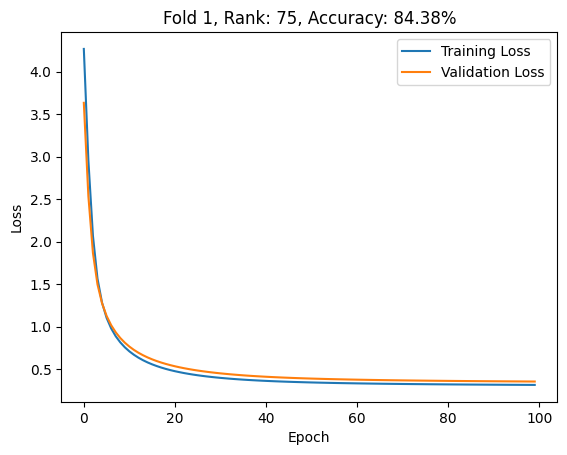


 Rank: 100 computation started for Fold 1

Epoch [1/100], Loss: 4.6298, Validation Loss: 3.8280
Epoch [2/100], Loss: 3.1336, Validation Loss: 2.6366
Epoch [3/100], Loss: 2.2006, Validation Loss: 1.9640
Epoch [4/100], Loss: 1.6902, Validation Loss: 1.5895
Epoch [5/100], Loss: 1.3915, Validation Loss: 1.3560
Epoch [6/100], Loss: 1.1953, Validation Loss: 1.1951
Epoch [7/100], Loss: 1.0544, Validation Loss: 1.0757
Epoch [8/100], Loss: 0.9474, Validation Loss: 0.9830
Epoch [9/100], Loss: 0.8626, Validation Loss: 0.9087
Epoch [10/100], Loss: 0.7942, Validation Loss: 0.8477
Epoch [11/100], Loss: 0.7378, Validation Loss: 0.7965
Epoch [12/100], Loss: 0.6907, Validation Loss: 0.7528
Epoch [13/100], Loss: 0.6505, Validation Loss: 0.7151
Epoch [14/100], Loss: 0.6162, Validation Loss: 0.6822
Epoch [15/100], Loss: 0.5863, Validation Loss: 0.6532
Epoch [16/100], Loss: 0.5602, Validation Loss: 0.6277
Epoch [17/100], Loss: 0.5373, Validation Loss: 0.6049
Epoch [18/100], Loss: 0.5171, Validation Loss: 

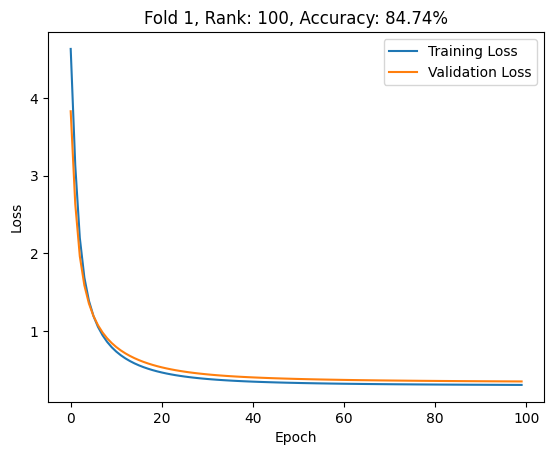


Fold 2/5

 Rank: 2 computation started for Fold 2

Epoch [1/100], Loss: 0.9945, Validation Loss: 0.8779
Epoch [2/100], Loss: 0.8006, Validation Loss: 0.7463
Epoch [3/100], Loss: 0.7005, Validation Loss: 0.6653
Epoch [4/100], Loss: 0.6301, Validation Loss: 0.6015
Epoch [5/100], Loss: 0.5724, Validation Loss: 0.5498
Epoch [6/100], Loss: 0.5275, Validation Loss: 0.5120
Epoch [7/100], Loss: 0.4963, Validation Loss: 0.4874
Epoch [8/100], Loss: 0.4765, Validation Loss: 0.4721
Epoch [9/100], Loss: 0.4644, Validation Loss: 0.4627
Epoch [10/100], Loss: 0.4567, Validation Loss: 0.4567
Epoch [11/100], Loss: 0.4518, Validation Loss: 0.4528
Epoch [12/100], Loss: 0.4485, Validation Loss: 0.4502
Epoch [13/100], Loss: 0.4462, Validation Loss: 0.4483
Epoch [14/100], Loss: 0.4446, Validation Loss: 0.4468
Epoch [15/100], Loss: 0.4433, Validation Loss: 0.4458
Epoch [16/100], Loss: 0.4424, Validation Loss: 0.4449
Epoch [17/100], Loss: 0.4416, Validation Loss: 0.4442
Epoch [18/100], Loss: 0.4409, Validatio

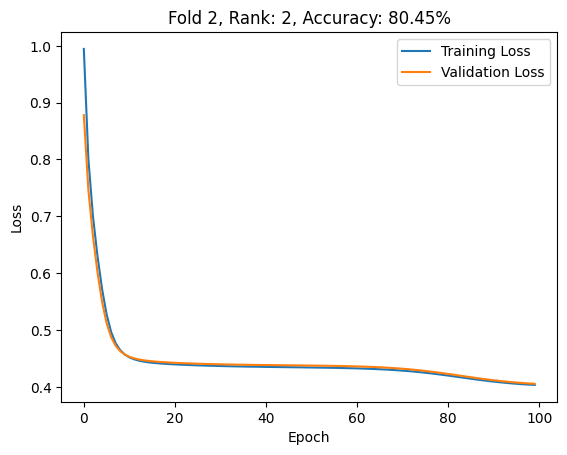


 Rank: 5 computation started for Fold 2

Epoch [1/100], Loss: 1.2108, Validation Loss: 1.0588
Epoch [2/100], Loss: 0.9577, Validation Loss: 0.8734
Epoch [3/100], Loss: 0.8083, Validation Loss: 0.7536
Epoch [4/100], Loss: 0.7033, Validation Loss: 0.6612
Epoch [5/100], Loss: 0.6194, Validation Loss: 0.5863
Epoch [6/100], Loss: 0.5539, Validation Loss: 0.5307
Epoch [7/100], Loss: 0.5077, Validation Loss: 0.4936
Epoch [8/100], Loss: 0.4778, Validation Loss: 0.4700
Epoch [9/100], Loss: 0.4586, Validation Loss: 0.4547
Epoch [10/100], Loss: 0.4458, Validation Loss: 0.4441
Epoch [11/100], Loss: 0.4366, Validation Loss: 0.4361
Epoch [12/100], Loss: 0.4296, Validation Loss: 0.4299
Epoch [13/100], Loss: 0.4239, Validation Loss: 0.4247
Epoch [14/100], Loss: 0.4192, Validation Loss: 0.4203
Epoch [15/100], Loss: 0.4151, Validation Loss: 0.4165
Epoch [16/100], Loss: 0.4117, Validation Loss: 0.4132
Epoch [17/100], Loss: 0.4086, Validation Loss: 0.4104
Epoch [18/100], Loss: 0.4060, Validation Loss: 0.

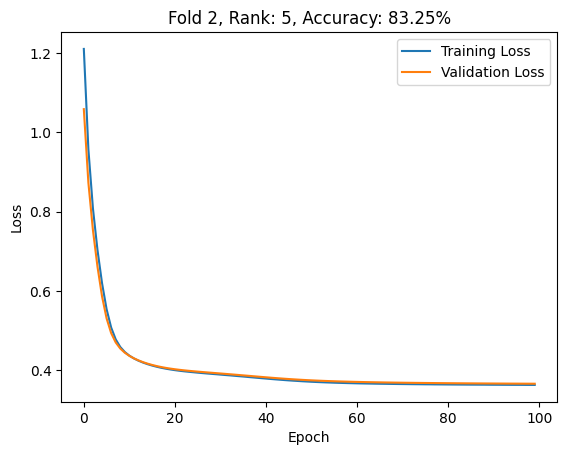


 Rank: 10 computation started for Fold 2

Epoch [1/100], Loss: 1.6394, Validation Loss: 1.3899
Epoch [2/100], Loss: 1.2155, Validation Loss: 1.0607
Epoch [3/100], Loss: 0.9401, Validation Loss: 0.8411
Epoch [4/100], Loss: 0.7566, Validation Loss: 0.6942
Epoch [5/100], Loss: 0.6371, Validation Loss: 0.6004
Epoch [6/100], Loss: 0.5624, Validation Loss: 0.5422
Epoch [7/100], Loss: 0.5160, Validation Loss: 0.5053
Epoch [8/100], Loss: 0.4859, Validation Loss: 0.4806
Epoch [9/100], Loss: 0.4651, Validation Loss: 0.4628
Epoch [10/100], Loss: 0.4496, Validation Loss: 0.4492
Epoch [11/100], Loss: 0.4376, Validation Loss: 0.4383
Epoch [12/100], Loss: 0.4278, Validation Loss: 0.4294
Epoch [13/100], Loss: 0.4197, Validation Loss: 0.4218
Epoch [14/100], Loss: 0.4128, Validation Loss: 0.4154
Epoch [15/100], Loss: 0.4069, Validation Loss: 0.4099
Epoch [16/100], Loss: 0.4019, Validation Loss: 0.4051
Epoch [17/100], Loss: 0.3976, Validation Loss: 0.4010
Epoch [18/100], Loss: 0.3938, Validation Loss: 0

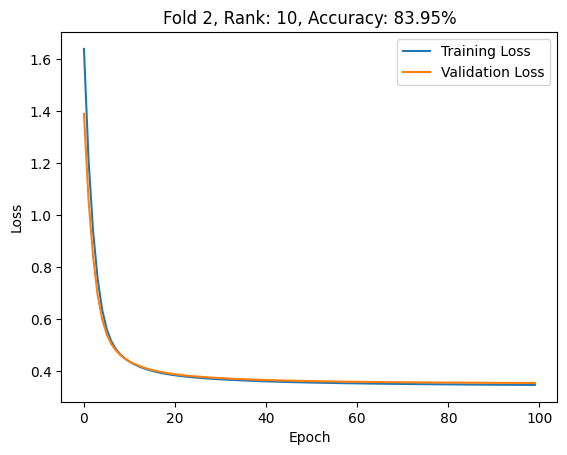


 Rank: 20 computation started for Fold 2

Epoch [1/100], Loss: 2.3053, Validation Loss: 1.9706
Epoch [2/100], Loss: 1.7116, Validation Loss: 1.4763
Epoch [3/100], Loss: 1.2776, Validation Loss: 1.1113
Epoch [4/100], Loss: 0.9700, Validation Loss: 0.8642
Epoch [5/100], Loss: 0.7745, Validation Loss: 0.7145
Epoch [6/100], Loss: 0.6588, Validation Loss: 0.6262
Epoch [7/100], Loss: 0.5889, Validation Loss: 0.5708
Epoch [8/100], Loss: 0.5431, Validation Loss: 0.5330
Epoch [9/100], Loss: 0.5108, Validation Loss: 0.5053
Epoch [10/100], Loss: 0.4866, Validation Loss: 0.4842
Epoch [11/100], Loss: 0.4678, Validation Loss: 0.4675
Epoch [12/100], Loss: 0.4528, Validation Loss: 0.4539
Epoch [13/100], Loss: 0.4404, Validation Loss: 0.4427
Epoch [14/100], Loss: 0.4301, Validation Loss: 0.4333
Epoch [15/100], Loss: 0.4214, Validation Loss: 0.4253
Epoch [16/100], Loss: 0.4140, Validation Loss: 0.4184
Epoch [17/100], Loss: 0.4075, Validation Loss: 0.4124
Epoch [18/100], Loss: 0.4019, Validation Loss: 0

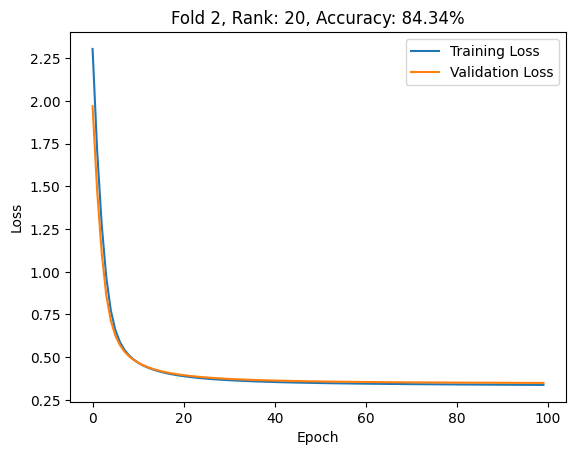


 Rank: 30 computation started for Fold 2

Epoch [1/100], Loss: 2.7478, Validation Loss: 2.3589
Epoch [2/100], Loss: 1.9905, Validation Loss: 1.7121
Epoch [3/100], Loss: 1.4479, Validation Loss: 1.2648
Epoch [4/100], Loss: 1.0932, Validation Loss: 0.9880
Epoch [5/100], Loss: 0.8804, Validation Loss: 0.8247
Epoch [6/100], Loss: 0.7529, Validation Loss: 0.7245
Epoch [7/100], Loss: 0.6717, Validation Loss: 0.6582
Epoch [8/100], Loss: 0.6156, Validation Loss: 0.6107
Epoch [9/100], Loss: 0.5740, Validation Loss: 0.5747
Epoch [10/100], Loss: 0.5420, Validation Loss: 0.5463
Epoch [11/100], Loss: 0.5162, Validation Loss: 0.5230
Epoch [12/100], Loss: 0.4950, Validation Loss: 0.5037
Epoch [13/100], Loss: 0.4773, Validation Loss: 0.4873
Epoch [14/100], Loss: 0.4623, Validation Loss: 0.4733
Epoch [15/100], Loss: 0.4494, Validation Loss: 0.4612
Epoch [16/100], Loss: 0.4383, Validation Loss: 0.4506
Epoch [17/100], Loss: 0.4287, Validation Loss: 0.4414
Epoch [18/100], Loss: 0.4201, Validation Loss: 0

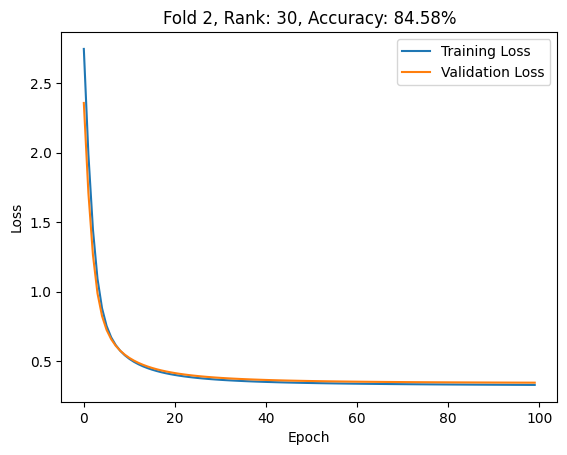


 Rank: 50 computation started for Fold 2

Epoch [1/100], Loss: 3.4972, Validation Loss: 2.9967
Epoch [2/100], Loss: 2.5030, Validation Loss: 2.1466
Epoch [3/100], Loss: 1.7900, Validation Loss: 1.5766
Epoch [4/100], Loss: 1.3481, Validation Loss: 1.2448
Epoch [5/100], Loss: 1.0942, Validation Loss: 1.0519
Epoch [6/100], Loss: 0.9404, Validation Loss: 0.9280
Epoch [7/100], Loss: 0.8376, Validation Loss: 0.8410
Epoch [8/100], Loss: 0.7629, Validation Loss: 0.7757
Epoch [9/100], Loss: 0.7057, Validation Loss: 0.7242
Epoch [10/100], Loss: 0.6600, Validation Loss: 0.6825
Epoch [11/100], Loss: 0.6226, Validation Loss: 0.6478
Epoch [12/100], Loss: 0.5912, Validation Loss: 0.6185
Epoch [13/100], Loss: 0.5646, Validation Loss: 0.5933
Epoch [14/100], Loss: 0.5417, Validation Loss: 0.5715
Epoch [15/100], Loss: 0.5219, Validation Loss: 0.5523
Epoch [16/100], Loss: 0.5045, Validation Loss: 0.5355
Epoch [17/100], Loss: 0.4891, Validation Loss: 0.5205
Epoch [18/100], Loss: 0.4755, Validation Loss: 0

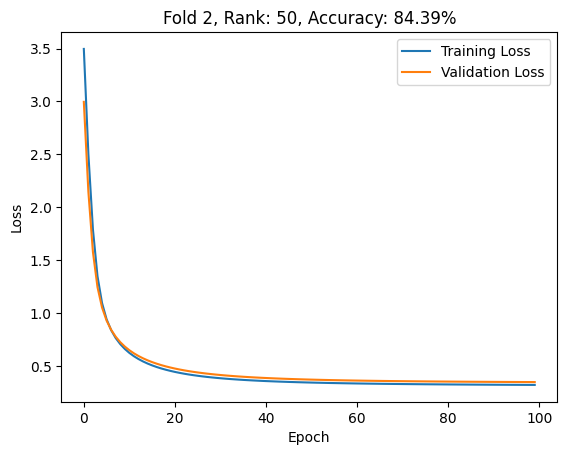


 Rank: 75 computation started for Fold 2

Epoch [1/100], Loss: 4.0559, Validation Loss: 3.3883
Epoch [2/100], Loss: 2.8245, Validation Loss: 2.3692
Epoch [3/100], Loss: 1.9925, Validation Loss: 1.7440
Epoch [4/100], Loss: 1.5140, Validation Loss: 1.3934
Epoch [5/100], Loss: 1.2414, Validation Loss: 1.1831
Epoch [6/100], Loss: 1.0706, Validation Loss: 1.0433
Epoch [7/100], Loss: 0.9530, Validation Loss: 0.9430
Epoch [8/100], Loss: 0.8661, Validation Loss: 0.8673
Epoch [9/100], Loss: 0.7985, Validation Loss: 0.8075
Epoch [10/100], Loss: 0.7439, Validation Loss: 0.7588
Epoch [11/100], Loss: 0.6987, Validation Loss: 0.7183
Epoch [12/100], Loss: 0.6603, Validation Loss: 0.6837
Epoch [13/100], Loss: 0.6275, Validation Loss: 0.6540
Epoch [14/100], Loss: 0.5989, Validation Loss: 0.6281
Epoch [15/100], Loss: 0.5739, Validation Loss: 0.6052
Epoch [16/100], Loss: 0.5520, Validation Loss: 0.5849
Epoch [17/100], Loss: 0.5323, Validation Loss: 0.5669
Epoch [18/100], Loss: 0.5149, Validation Loss: 0

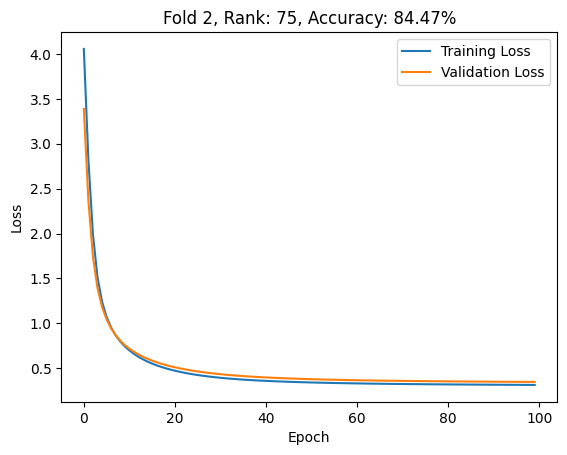


 Rank: 100 computation started for Fold 2

Epoch [1/100], Loss: 5.0810, Validation Loss: 4.2777
Epoch [2/100], Loss: 3.4750, Validation Loss: 2.9307
Epoch [3/100], Loss: 2.3893, Validation Loss: 2.1182
Epoch [4/100], Loss: 1.7823, Validation Loss: 1.6744
Epoch [5/100], Loss: 1.4409, Validation Loss: 1.4118
Epoch [6/100], Loss: 1.2261, Validation Loss: 1.2369
Epoch [7/100], Loss: 1.0775, Validation Loss: 1.1097
Epoch [8/100], Loss: 0.9668, Validation Loss: 1.0115
Epoch [9/100], Loss: 0.8804, Validation Loss: 0.9325
Epoch [10/100], Loss: 0.8107, Validation Loss: 0.8671
Epoch [11/100], Loss: 0.7532, Validation Loss: 0.8122
Epoch [12/100], Loss: 0.7049, Validation Loss: 0.7654
Epoch [13/100], Loss: 0.6637, Validation Loss: 0.7249
Epoch [14/100], Loss: 0.6282, Validation Loss: 0.6895
Epoch [15/100], Loss: 0.5972, Validation Loss: 0.6585
Epoch [16/100], Loss: 0.5702, Validation Loss: 0.6310
Epoch [17/100], Loss: 0.5464, Validation Loss: 0.6066
Epoch [18/100], Loss: 0.5253, Validation Loss: 

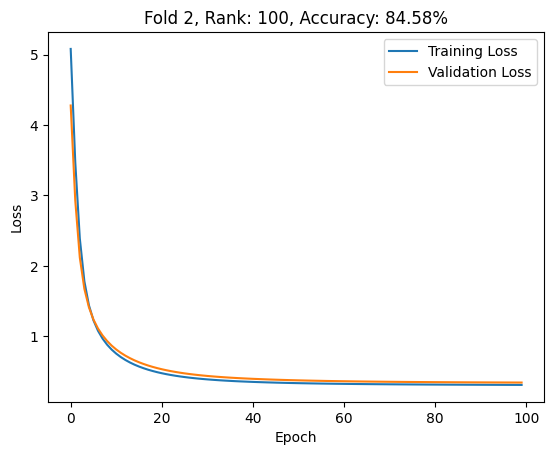


Fold 3/5

 Rank: 2 computation started for Fold 3

Epoch [1/100], Loss: 0.9229, Validation Loss: 0.8374
Epoch [2/100], Loss: 0.7796, Validation Loss: 0.7417
Epoch [3/100], Loss: 0.7056, Validation Loss: 0.6800
Epoch [4/100], Loss: 0.6487, Validation Loss: 0.6246
Epoch [5/100], Loss: 0.5946, Validation Loss: 0.5718
Epoch [6/100], Loss: 0.5462, Validation Loss: 0.5279
Epoch [7/100], Loss: 0.5093, Validation Loss: 0.4970
Epoch [8/100], Loss: 0.4848, Validation Loss: 0.4775
Epoch [9/100], Loss: 0.4698, Validation Loss: 0.4656
Epoch [10/100], Loss: 0.4606, Validation Loss: 0.4583
Epoch [11/100], Loss: 0.4549, Validation Loss: 0.4536
Epoch [12/100], Loss: 0.4512, Validation Loss: 0.4505
Epoch [13/100], Loss: 0.4486, Validation Loss: 0.4483
Epoch [14/100], Loss: 0.4468, Validation Loss: 0.4467
Epoch [15/100], Loss: 0.4453, Validation Loss: 0.4453
Epoch [16/100], Loss: 0.4440, Validation Loss: 0.4441
Epoch [17/100], Loss: 0.4429, Validation Loss: 0.4429
Epoch [18/100], Loss: 0.4417, Validatio

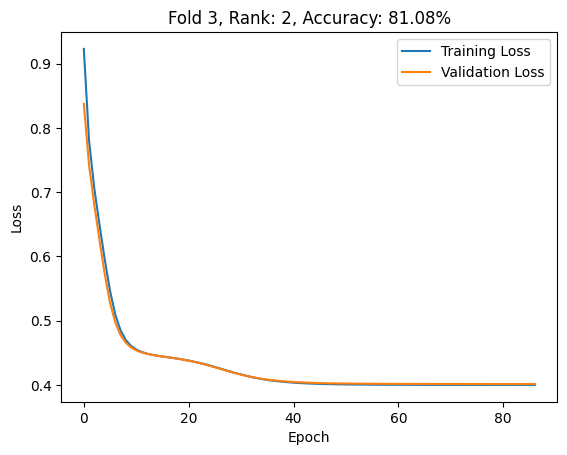


 Rank: 5 computation started for Fold 3

Epoch [1/100], Loss: 1.1639, Validation Loss: 1.0369
Epoch [2/100], Loss: 0.9488, Validation Loss: 0.8838
Epoch [3/100], Loss: 0.8326, Validation Loss: 0.7958
Epoch [4/100], Loss: 0.7604, Validation Loss: 0.7350
Epoch [5/100], Loss: 0.7043, Validation Loss: 0.6811
Epoch [6/100], Loss: 0.6498, Validation Loss: 0.6251
Epoch [7/100], Loss: 0.5933, Validation Loss: 0.5688
Epoch [8/100], Loss: 0.5408, Validation Loss: 0.5207
Epoch [9/100], Loss: 0.4996, Validation Loss: 0.4858
Epoch [10/100], Loss: 0.4712, Validation Loss: 0.4626
Epoch [11/100], Loss: 0.4525, Validation Loss: 0.4472
Epoch [12/100], Loss: 0.4400, Validation Loss: 0.4365
Epoch [13/100], Loss: 0.4309, Validation Loss: 0.4286
Epoch [14/100], Loss: 0.4240, Validation Loss: 0.4223
Epoch [15/100], Loss: 0.4183, Validation Loss: 0.4171
Epoch [16/100], Loss: 0.4134, Validation Loss: 0.4126
Epoch [17/100], Loss: 0.4093, Validation Loss: 0.4087
Epoch [18/100], Loss: 0.4056, Validation Loss: 0.

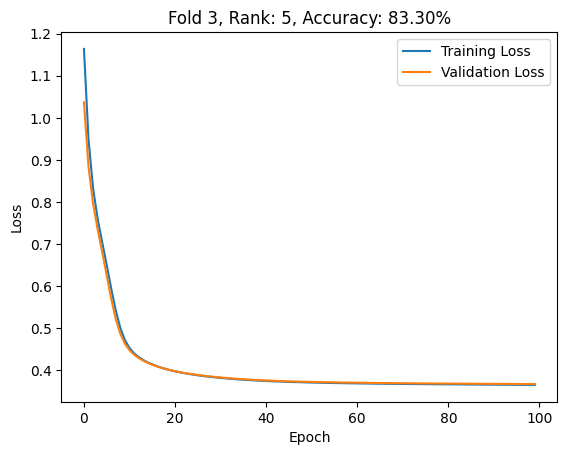


 Rank: 10 computation started for Fold 3

Epoch [1/100], Loss: 1.5248, Validation Loss: 1.3023
Epoch [2/100], Loss: 1.1271, Validation Loss: 0.9814
Epoch [3/100], Loss: 0.8635, Validation Loss: 0.7702
Epoch [4/100], Loss: 0.6957, Validation Loss: 0.6406
Epoch [5/100], Loss: 0.5957, Validation Loss: 0.5645
Epoch [6/100], Loss: 0.5365, Validation Loss: 0.5184
Epoch [7/100], Loss: 0.4993, Validation Loss: 0.4882
Epoch [8/100], Loss: 0.4740, Validation Loss: 0.4668
Epoch [9/100], Loss: 0.4555, Validation Loss: 0.4507
Epoch [10/100], Loss: 0.4413, Validation Loss: 0.4381
Epoch [11/100], Loss: 0.4300, Validation Loss: 0.4280
Epoch [12/100], Loss: 0.4208, Validation Loss: 0.4197
Epoch [13/100], Loss: 0.4132, Validation Loss: 0.4129
Epoch [14/100], Loss: 0.4068, Validation Loss: 0.4071
Epoch [15/100], Loss: 0.4015, Validation Loss: 0.4023
Epoch [16/100], Loss: 0.3969, Validation Loss: 0.3981
Epoch [17/100], Loss: 0.3930, Validation Loss: 0.3946
Epoch [18/100], Loss: 0.3896, Validation Loss: 0

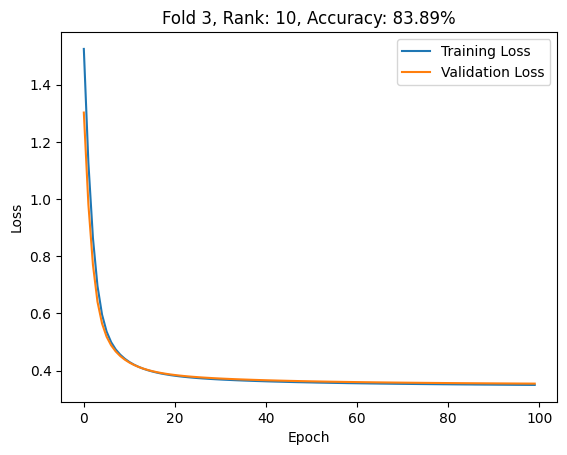


 Rank: 20 computation started for Fold 3

Epoch [1/100], Loss: 2.2767, Validation Loss: 1.9407
Epoch [2/100], Loss: 1.6429, Validation Loss: 1.4102
Epoch [3/100], Loss: 1.2019, Validation Loss: 1.0532
Epoch [4/100], Loss: 0.9220, Validation Loss: 0.8371
Epoch [5/100], Loss: 0.7577, Validation Loss: 0.7108
Epoch [6/100], Loss: 0.6598, Validation Loss: 0.6328
Epoch [7/100], Loss: 0.5966, Validation Loss: 0.5803
Epoch [8/100], Loss: 0.5524, Validation Loss: 0.5426
Epoch [9/100], Loss: 0.5197, Validation Loss: 0.5141
Epoch [10/100], Loss: 0.4945, Validation Loss: 0.4918
Epoch [11/100], Loss: 0.4745, Validation Loss: 0.4739
Epoch [12/100], Loss: 0.4583, Validation Loss: 0.4593
Epoch [13/100], Loss: 0.4448, Validation Loss: 0.4471
Epoch [14/100], Loss: 0.4336, Validation Loss: 0.4369
Epoch [15/100], Loss: 0.4241, Validation Loss: 0.4282
Epoch [16/100], Loss: 0.4160, Validation Loss: 0.4207
Epoch [17/100], Loss: 0.4090, Validation Loss: 0.4142
Epoch [18/100], Loss: 0.4028, Validation Loss: 0

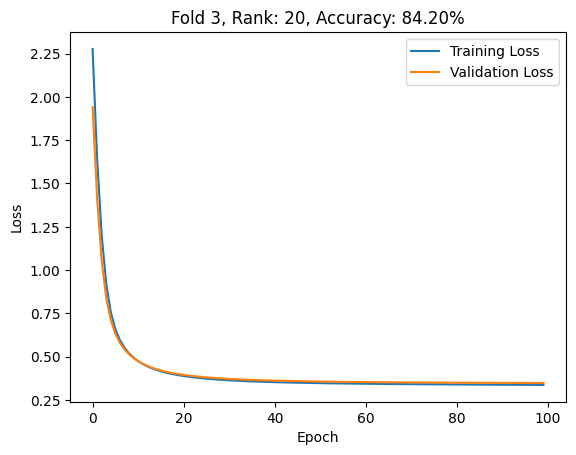


 Rank: 30 computation started for Fold 3

Epoch [1/100], Loss: 2.7949, Validation Loss: 2.4215
Epoch [2/100], Loss: 2.0509, Validation Loss: 1.7793
Epoch [3/100], Loss: 1.4981, Validation Loss: 1.3182
Epoch [4/100], Loss: 1.1257, Validation Loss: 1.0265
Epoch [5/100], Loss: 0.9018, Validation Loss: 0.8547
Epoch [6/100], Loss: 0.7697, Validation Loss: 0.7497
Epoch [7/100], Loss: 0.6862, Validation Loss: 0.6798
Epoch [8/100], Loss: 0.6287, Validation Loss: 0.6297
Epoch [9/100], Loss: 0.5863, Validation Loss: 0.5916
Epoch [10/100], Loss: 0.5534, Validation Loss: 0.5613
Epoch [11/100], Loss: 0.5269, Validation Loss: 0.5366
Epoch [12/100], Loss: 0.5051, Validation Loss: 0.5160
Epoch [13/100], Loss: 0.4868, Validation Loss: 0.4985
Epoch [14/100], Loss: 0.4713, Validation Loss: 0.4835
Epoch [15/100], Loss: 0.4579, Validation Loss: 0.4704
Epoch [16/100], Loss: 0.4462, Validation Loss: 0.4591
Epoch [17/100], Loss: 0.4361, Validation Loss: 0.4490
Epoch [18/100], Loss: 0.4271, Validation Loss: 0

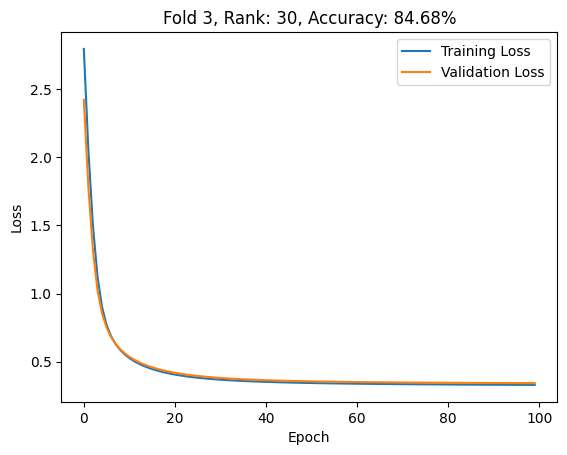


 Rank: 50 computation started for Fold 3

Epoch [1/100], Loss: 3.6753, Validation Loss: 3.1645
Epoch [2/100], Loss: 2.6362, Validation Loss: 2.2737
Epoch [3/100], Loss: 1.8862, Validation Loss: 1.6661
Epoch [4/100], Loss: 1.4127, Validation Loss: 1.3011
Epoch [5/100], Loss: 1.1355, Validation Loss: 1.0848
Epoch [6/100], Loss: 0.9667, Validation Loss: 0.9466
Epoch [7/100], Loss: 0.8545, Validation Loss: 0.8505
Epoch [8/100], Loss: 0.7738, Validation Loss: 0.7790
Epoch [9/100], Loss: 0.7125, Validation Loss: 0.7234
Epoch [10/100], Loss: 0.6641, Validation Loss: 0.6787
Epoch [11/100], Loss: 0.6249, Validation Loss: 0.6422
Epoch [12/100], Loss: 0.5925, Validation Loss: 0.6117
Epoch [13/100], Loss: 0.5654, Validation Loss: 0.5859
Epoch [14/100], Loss: 0.5421, Validation Loss: 0.5637
Epoch [15/100], Loss: 0.5222, Validation Loss: 0.5443
Epoch [16/100], Loss: 0.5047, Validation Loss: 0.5274
Epoch [17/100], Loss: 0.4894, Validation Loss: 0.5125
Epoch [18/100], Loss: 0.4758, Validation Loss: 0

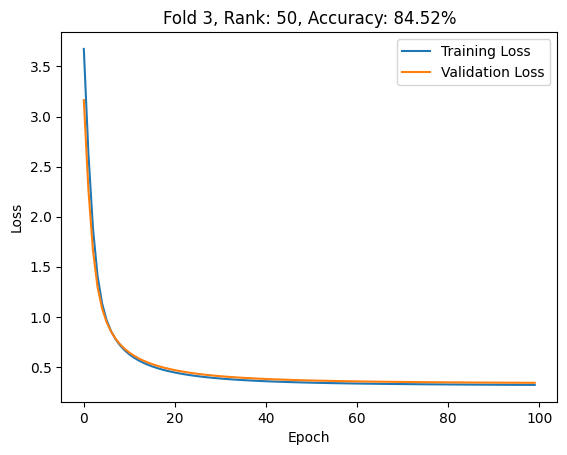


 Rank: 75 computation started for Fold 3

Epoch [1/100], Loss: 4.2673, Validation Loss: 3.6176
Epoch [2/100], Loss: 2.9744, Validation Loss: 2.5321
Epoch [3/100], Loss: 2.0858, Validation Loss: 1.8440
Epoch [4/100], Loss: 1.5682, Validation Loss: 1.4563
Epoch [5/100], Loss: 1.2751, Validation Loss: 1.2295
Epoch [6/100], Loss: 1.0949, Validation Loss: 1.0823
Epoch [7/100], Loss: 0.9719, Validation Loss: 0.9773
Epoch [8/100], Loss: 0.8808, Validation Loss: 0.8968
Epoch [9/100], Loss: 0.8097, Validation Loss: 0.8328
Epoch [10/100], Loss: 0.7521, Validation Loss: 0.7802
Epoch [11/100], Loss: 0.7046, Validation Loss: 0.7363
Epoch [12/100], Loss: 0.6645, Validation Loss: 0.6988
Epoch [13/100], Loss: 0.6303, Validation Loss: 0.6665
Epoch [14/100], Loss: 0.6009, Validation Loss: 0.6383
Epoch [15/100], Loss: 0.5750, Validation Loss: 0.6136
Epoch [16/100], Loss: 0.5524, Validation Loss: 0.5917
Epoch [17/100], Loss: 0.5325, Validation Loss: 0.5722
Epoch [18/100], Loss: 0.5147, Validation Loss: 0

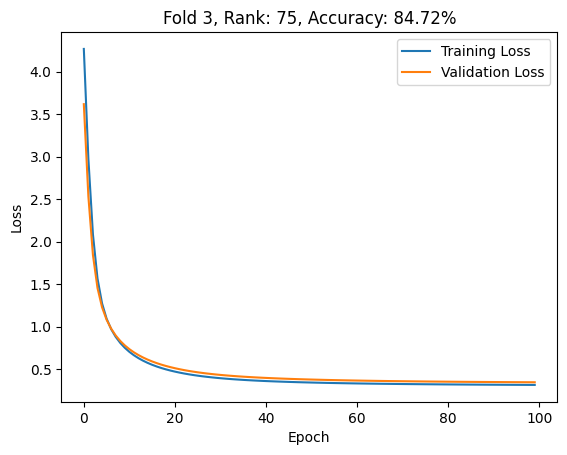


 Rank: 100 computation started for Fold 3

Epoch [1/100], Loss: 4.8423, Validation Loss: 3.9544
Epoch [2/100], Loss: 3.2811, Validation Loss: 2.6811
Epoch [3/100], Loss: 2.2580, Validation Loss: 1.9448
Epoch [4/100], Loss: 1.7043, Validation Loss: 1.5557
Epoch [5/100], Loss: 1.3964, Validation Loss: 1.3229
Epoch [6/100], Loss: 1.1995, Validation Loss: 1.1644
Epoch [7/100], Loss: 1.0592, Validation Loss: 1.0469
Epoch [8/100], Loss: 0.9526, Validation Loss: 0.9552
Epoch [9/100], Loss: 0.8683, Validation Loss: 0.8811
Epoch [10/100], Loss: 0.7995, Validation Loss: 0.8195
Epoch [11/100], Loss: 0.7423, Validation Loss: 0.7678
Epoch [12/100], Loss: 0.6943, Validation Loss: 0.7237
Epoch [13/100], Loss: 0.6533, Validation Loss: 0.6855
Epoch [14/100], Loss: 0.6181, Validation Loss: 0.6523
Epoch [15/100], Loss: 0.5876, Validation Loss: 0.6232
Epoch [16/100], Loss: 0.5605, Validation Loss: 0.5976
Epoch [17/100], Loss: 0.5369, Validation Loss: 0.5747
Epoch [18/100], Loss: 0.5161, Validation Loss: 

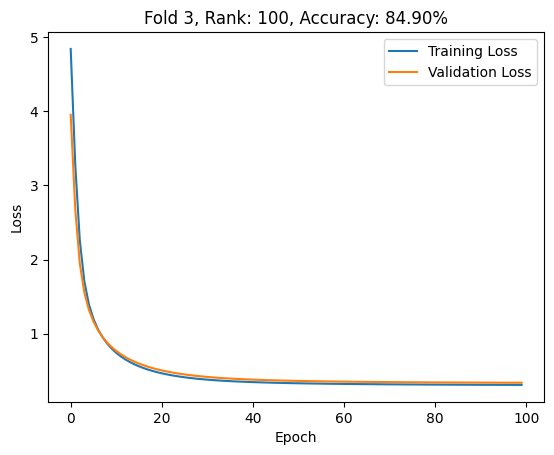


Fold 4/5

 Rank: 2 computation started for Fold 4

Epoch [1/100], Loss: 0.9213, Validation Loss: 0.8395
Epoch [2/100], Loss: 0.7816, Validation Loss: 0.7453
Epoch [3/100], Loss: 0.7087, Validation Loss: 0.6842
Epoch [4/100], Loss: 0.6526, Validation Loss: 0.6294
Epoch [5/100], Loss: 0.5992, Validation Loss: 0.5768
Epoch [6/100], Loss: 0.5506, Validation Loss: 0.5327
Epoch [7/100], Loss: 0.5129, Validation Loss: 0.5011
Epoch [8/100], Loss: 0.4874, Validation Loss: 0.4808
Epoch [9/100], Loss: 0.4714, Validation Loss: 0.4682
Epoch [10/100], Loss: 0.4616, Validation Loss: 0.4605
Epoch [11/100], Loss: 0.4555, Validation Loss: 0.4555
Epoch [12/100], Loss: 0.4516, Validation Loss: 0.4521
Epoch [13/100], Loss: 0.4489, Validation Loss: 0.4498
Epoch [14/100], Loss: 0.4470, Validation Loss: 0.4481
Epoch [15/100], Loss: 0.4455, Validation Loss: 0.4467
Epoch [16/100], Loss: 0.4443, Validation Loss: 0.4455
Epoch [17/100], Loss: 0.4433, Validation Loss: 0.4445
Epoch [18/100], Loss: 0.4423, Validatio

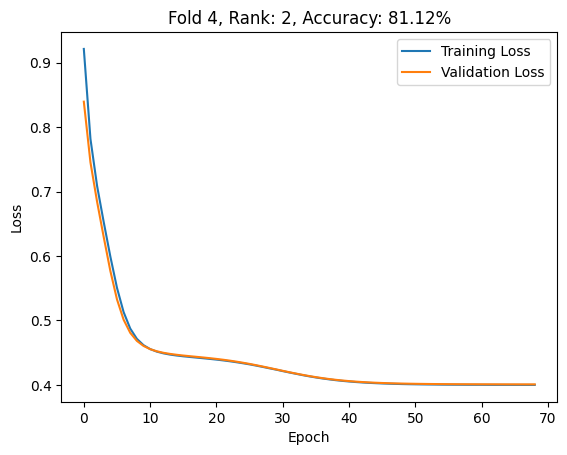


 Rank: 5 computation started for Fold 4

Epoch [1/100], Loss: 1.1472, Validation Loss: 1.0029
Epoch [2/100], Loss: 0.9011, Validation Loss: 0.8168
Epoch [3/100], Loss: 0.7506, Validation Loss: 0.6942
Epoch [4/100], Loss: 0.6468, Validation Loss: 0.6068
Epoch [5/100], Loss: 0.5734, Validation Loss: 0.5464
Epoch [6/100], Loss: 0.5238, Validation Loss: 0.5069
Epoch [7/100], Loss: 0.4918, Validation Loss: 0.4815
Epoch [8/100], Loss: 0.4709, Validation Loss: 0.4647
Epoch [9/100], Loss: 0.4566, Validation Loss: 0.4527
Epoch [10/100], Loss: 0.4460, Validation Loss: 0.4436
Epoch [11/100], Loss: 0.4379, Validation Loss: 0.4363
Epoch [12/100], Loss: 0.4311, Validation Loss: 0.4301
Epoch [13/100], Loss: 0.4253, Validation Loss: 0.4247
Epoch [14/100], Loss: 0.4203, Validation Loss: 0.4200
Epoch [15/100], Loss: 0.4158, Validation Loss: 0.4157
Epoch [16/100], Loss: 0.4118, Validation Loss: 0.4119
Epoch [17/100], Loss: 0.4084, Validation Loss: 0.4086
Epoch [18/100], Loss: 0.4052, Validation Loss: 0.

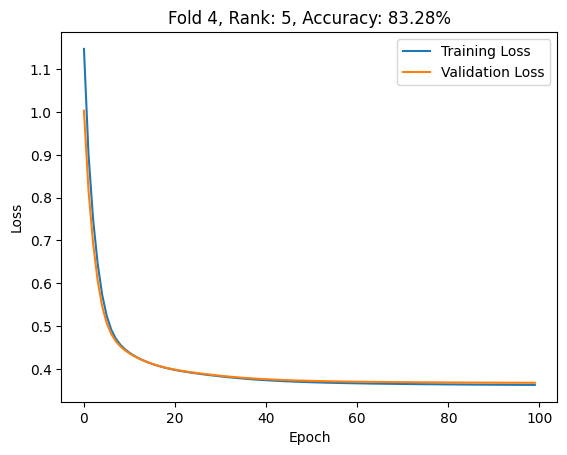


 Rank: 10 computation started for Fold 4

Epoch [1/100], Loss: 1.6863, Validation Loss: 1.4481
Epoch [2/100], Loss: 1.2590, Validation Loss: 1.1061
Epoch [3/100], Loss: 0.9762, Validation Loss: 0.8732
Epoch [4/100], Loss: 0.7832, Validation Loss: 0.7150
Epoch [5/100], Loss: 0.6549, Validation Loss: 0.6124
Epoch [6/100], Loss: 0.5730, Validation Loss: 0.5476
Epoch [7/100], Loss: 0.5214, Validation Loss: 0.5061
Epoch [8/100], Loss: 0.4877, Validation Loss: 0.4782
Epoch [9/100], Loss: 0.4645, Validation Loss: 0.4584
Epoch [10/100], Loss: 0.4478, Validation Loss: 0.4438
Epoch [11/100], Loss: 0.4350, Validation Loss: 0.4326
Epoch [12/100], Loss: 0.4253, Validation Loss: 0.4239
Epoch [13/100], Loss: 0.4175, Validation Loss: 0.4169
Epoch [14/100], Loss: 0.4112, Validation Loss: 0.4112
Epoch [15/100], Loss: 0.4060, Validation Loss: 0.4065
Epoch [16/100], Loss: 0.4015, Validation Loss: 0.4026
Epoch [17/100], Loss: 0.3978, Validation Loss: 0.3992
Epoch [18/100], Loss: 0.3945, Validation Loss: 0

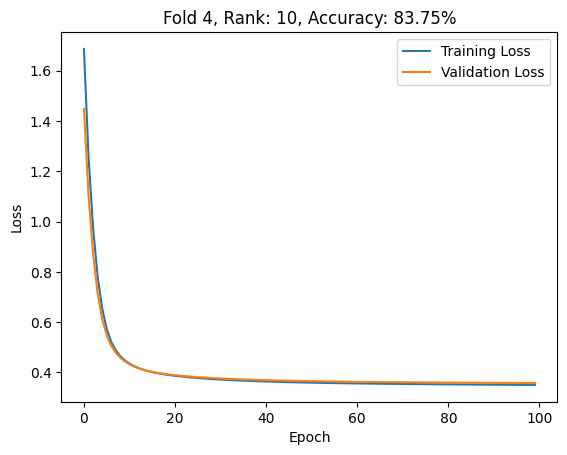


 Rank: 20 computation started for Fold 4

Epoch [1/100], Loss: 2.1948, Validation Loss: 1.8712
Epoch [2/100], Loss: 1.6135, Validation Loss: 1.3842
Epoch [3/100], Loss: 1.1961, Validation Loss: 1.0437
Epoch [4/100], Loss: 0.9212, Validation Loss: 0.8328
Epoch [5/100], Loss: 0.7578, Validation Loss: 0.7102
Epoch [6/100], Loss: 0.6608, Validation Loss: 0.6350
Epoch [7/100], Loss: 0.5987, Validation Loss: 0.5843
Epoch [8/100], Loss: 0.5551, Validation Loss: 0.5472
Epoch [9/100], Loss: 0.5221, Validation Loss: 0.5186
Epoch [10/100], Loss: 0.4964, Validation Loss: 0.4959
Epoch [11/100], Loss: 0.4757, Validation Loss: 0.4773
Epoch [12/100], Loss: 0.4587, Validation Loss: 0.4620
Epoch [13/100], Loss: 0.4446, Validation Loss: 0.4491
Epoch [14/100], Loss: 0.4328, Validation Loss: 0.4383
Epoch [15/100], Loss: 0.4228, Validation Loss: 0.4292
Epoch [16/100], Loss: 0.4143, Validation Loss: 0.4214
Epoch [17/100], Loss: 0.4071, Validation Loss: 0.4147
Epoch [18/100], Loss: 0.4009, Validation Loss: 0

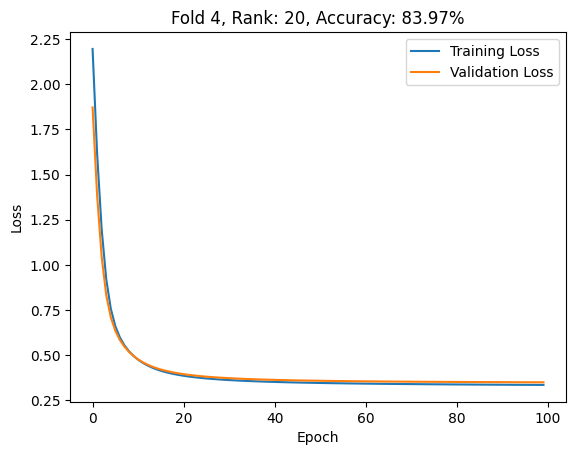


 Rank: 30 computation started for Fold 4

Epoch [1/100], Loss: 2.7361, Validation Loss: 2.3455
Epoch [2/100], Loss: 2.0226, Validation Loss: 1.7379
Epoch [3/100], Loss: 1.4939, Validation Loss: 1.2989
Epoch [4/100], Loss: 1.1316, Validation Loss: 1.0157
Epoch [5/100], Loss: 0.9070, Validation Loss: 0.8445
Epoch [6/100], Loss: 0.7703, Validation Loss: 0.7377
Epoch [7/100], Loss: 0.6826, Validation Loss: 0.6661
Epoch [8/100], Loss: 0.6220, Validation Loss: 0.6148
Epoch [9/100], Loss: 0.5773, Validation Loss: 0.5759
Epoch [10/100], Loss: 0.5429, Validation Loss: 0.5455
Epoch [11/100], Loss: 0.5155, Validation Loss: 0.5209
Epoch [12/100], Loss: 0.4930, Validation Loss: 0.5007
Epoch [13/100], Loss: 0.4745, Validation Loss: 0.4838
Epoch [14/100], Loss: 0.4589, Validation Loss: 0.4696
Epoch [15/100], Loss: 0.4457, Validation Loss: 0.4574
Epoch [16/100], Loss: 0.4344, Validation Loss: 0.4469
Epoch [17/100], Loss: 0.4246, Validation Loss: 0.4378
Epoch [18/100], Loss: 0.4161, Validation Loss: 0

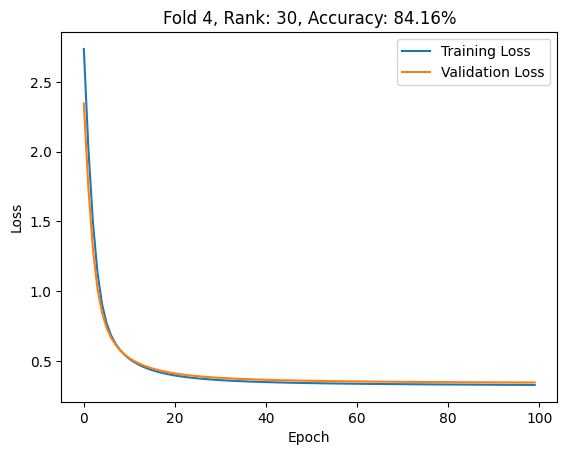


 Rank: 50 computation started for Fold 4

Epoch [1/100], Loss: 3.4873, Validation Loss: 2.9805
Epoch [2/100], Loss: 2.4756, Validation Loss: 2.1254
Epoch [3/100], Loss: 1.7672, Validation Loss: 1.5757
Epoch [4/100], Loss: 1.3480, Validation Loss: 1.2611
Epoch [5/100], Loss: 1.1087, Validation Loss: 1.0735
Epoch [6/100], Loss: 0.9585, Validation Loss: 0.9491
Epoch [7/100], Loss: 0.8540, Validation Loss: 0.8594
Epoch [8/100], Loss: 0.7766, Validation Loss: 0.7909
Epoch [9/100], Loss: 0.7165, Validation Loss: 0.7368
Epoch [10/100], Loss: 0.6687, Validation Loss: 0.6931
Epoch [11/100], Loss: 0.6295, Validation Loss: 0.6568
Epoch [12/100], Loss: 0.5968, Validation Loss: 0.6264
Epoch [13/100], Loss: 0.5693, Validation Loss: 0.6004
Epoch [14/100], Loss: 0.5458, Validation Loss: 0.5781
Epoch [15/100], Loss: 0.5254, Validation Loss: 0.5585
Epoch [16/100], Loss: 0.5076, Validation Loss: 0.5414
Epoch [17/100], Loss: 0.4919, Validation Loss: 0.5263
Epoch [18/100], Loss: 0.4780, Validation Loss: 0

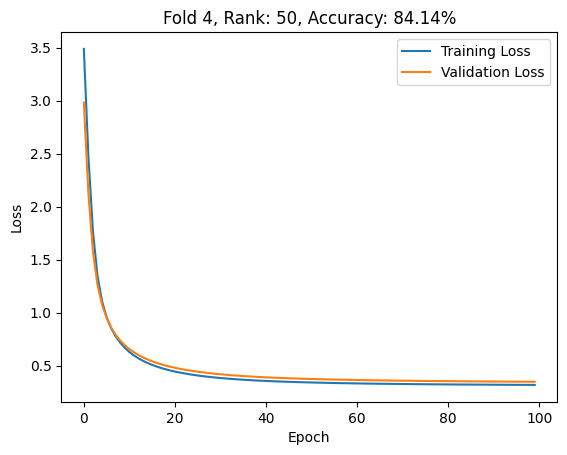


 Rank: 75 computation started for Fold 4

Epoch [1/100], Loss: 4.0223, Validation Loss: 3.3617
Epoch [2/100], Loss: 2.7510, Validation Loss: 2.3225
Epoch [3/100], Loss: 1.9267, Validation Loss: 1.7145
Epoch [4/100], Loss: 1.4698, Validation Loss: 1.3809
Epoch [5/100], Loss: 1.2125, Validation Loss: 1.1819
Epoch [6/100], Loss: 1.0498, Validation Loss: 1.0478
Epoch [7/100], Loss: 0.9352, Validation Loss: 0.9497
Epoch [8/100], Loss: 0.8490, Validation Loss: 0.8736
Epoch [9/100], Loss: 0.7807, Validation Loss: 0.8124
Epoch [10/100], Loss: 0.7253, Validation Loss: 0.7621
Epoch [11/100], Loss: 0.6792, Validation Loss: 0.7200
Epoch [12/100], Loss: 0.6404, Validation Loss: 0.6841
Epoch [13/100], Loss: 0.6074, Validation Loss: 0.6533
Epoch [14/100], Loss: 0.5790, Validation Loss: 0.6266
Epoch [15/100], Loss: 0.5546, Validation Loss: 0.6033
Epoch [16/100], Loss: 0.5330, Validation Loss: 0.5827
Epoch [17/100], Loss: 0.5142, Validation Loss: 0.5646
Epoch [18/100], Loss: 0.4976, Validation Loss: 0

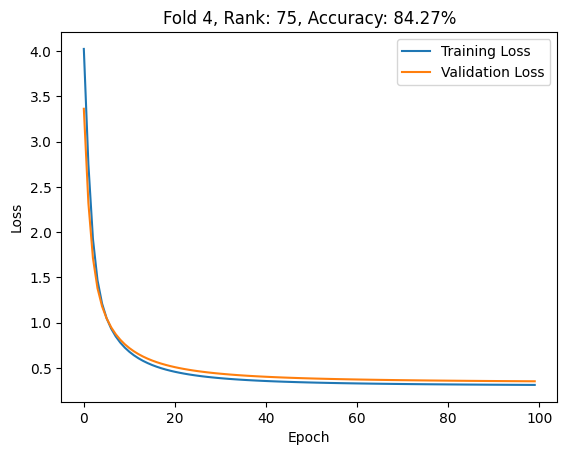


 Rank: 100 computation started for Fold 4

Epoch [1/100], Loss: 5.0528, Validation Loss: 4.2185
Epoch [2/100], Loss: 3.4675, Validation Loss: 2.8799
Epoch [3/100], Loss: 2.3631, Validation Loss: 2.0519
Epoch [4/100], Loss: 1.7387, Validation Loss: 1.6081
Epoch [5/100], Loss: 1.3972, Validation Loss: 1.3524
Epoch [6/100], Loss: 1.1863, Validation Loss: 1.1835
Epoch [7/100], Loss: 1.0408, Validation Loss: 1.0606
Epoch [8/100], Loss: 0.9324, Validation Loss: 0.9663
Epoch [9/100], Loss: 0.8478, Validation Loss: 0.8911
Epoch [10/100], Loss: 0.7800, Validation Loss: 0.8296
Epoch [11/100], Loss: 0.7243, Validation Loss: 0.7781
Epoch [12/100], Loss: 0.6776, Validation Loss: 0.7344
Epoch [13/100], Loss: 0.6380, Validation Loss: 0.6967
Epoch [14/100], Loss: 0.6040, Validation Loss: 0.6639
Epoch [15/100], Loss: 0.5745, Validation Loss: 0.6350
Epoch [16/100], Loss: 0.5487, Validation Loss: 0.6096
Epoch [17/100], Loss: 0.5262, Validation Loss: 0.5872
Epoch [18/100], Loss: 0.5063, Validation Loss: 

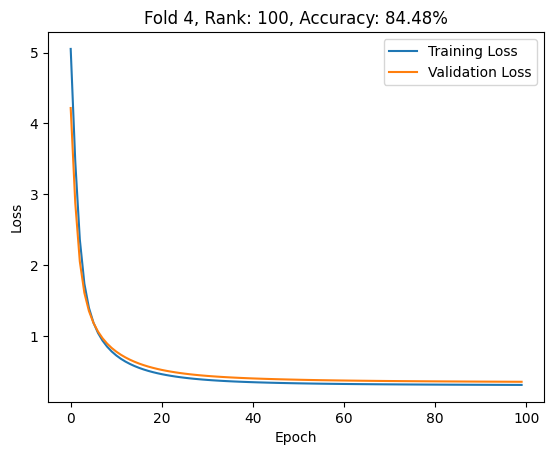


Fold 5/5

 Rank: 2 computation started for Fold 5

Epoch [1/100], Loss: 0.9170, Validation Loss: 0.8262
Epoch [2/100], Loss: 0.7768, Validation Loss: 0.7343
Epoch [3/100], Loss: 0.7033, Validation Loss: 0.6734
Epoch [4/100], Loss: 0.6456, Validation Loss: 0.6174
Epoch [5/100], Loss: 0.5902, Validation Loss: 0.5635
Epoch [6/100], Loss: 0.5404, Validation Loss: 0.5188
Epoch [7/100], Loss: 0.5026, Validation Loss: 0.4877
Epoch [8/100], Loss: 0.4778, Validation Loss: 0.4683
Epoch [9/100], Loss: 0.4625, Validation Loss: 0.4563
Epoch [10/100], Loss: 0.4530, Validation Loss: 0.4487
Epoch [11/100], Loss: 0.4468, Validation Loss: 0.4436
Epoch [12/100], Loss: 0.4424, Validation Loss: 0.4398
Epoch [13/100], Loss: 0.4391, Validation Loss: 0.4367
Epoch [14/100], Loss: 0.4362, Validation Loss: 0.4340
Epoch [15/100], Loss: 0.4338, Validation Loss: 0.4315
Epoch [16/100], Loss: 0.4314, Validation Loss: 0.4291
Epoch [17/100], Loss: 0.4291, Validation Loss: 0.4269
Epoch [18/100], Loss: 0.4269, Validatio

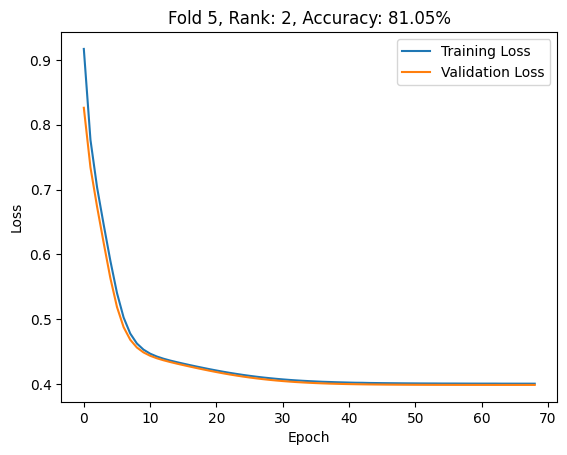


 Rank: 5 computation started for Fold 5

Epoch [1/100], Loss: 1.1854, Validation Loss: 1.0358
Epoch [2/100], Loss: 0.9328, Validation Loss: 0.8473
Epoch [3/100], Loss: 0.7821, Validation Loss: 0.7242
Epoch [4/100], Loss: 0.6767, Validation Loss: 0.6323
Epoch [5/100], Loss: 0.5966, Validation Loss: 0.5628
Epoch [6/100], Loss: 0.5376, Validation Loss: 0.5135
Epoch [7/100], Loss: 0.4971, Validation Loss: 0.4807
Epoch [8/100], Loss: 0.4703, Validation Loss: 0.4591
Epoch [9/100], Loss: 0.4525, Validation Loss: 0.4447
Epoch [10/100], Loss: 0.4403, Validation Loss: 0.4345
Epoch [11/100], Loss: 0.4315, Validation Loss: 0.4270
Epoch [12/100], Loss: 0.4249, Validation Loss: 0.4213
Epoch [13/100], Loss: 0.4198, Validation Loss: 0.4168
Epoch [14/100], Loss: 0.4158, Validation Loss: 0.4132
Epoch [15/100], Loss: 0.4125, Validation Loss: 0.4103
Epoch [16/100], Loss: 0.4098, Validation Loss: 0.4078
Epoch [17/100], Loss: 0.4075, Validation Loss: 0.4057
Epoch [18/100], Loss: 0.4057, Validation Loss: 0.

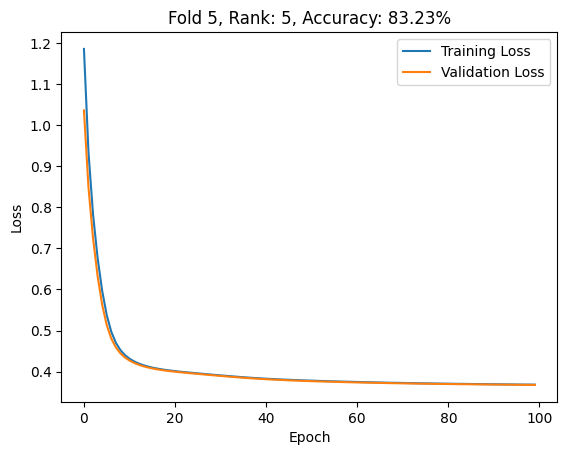


 Rank: 10 computation started for Fold 5

Epoch [1/100], Loss: 1.6513, Validation Loss: 1.4084
Epoch [2/100], Loss: 1.2249, Validation Loss: 1.0733
Epoch [3/100], Loss: 0.9489, Validation Loss: 0.8470
Epoch [4/100], Loss: 0.7613, Validation Loss: 0.6930
Epoch [5/100], Loss: 0.6373, Validation Loss: 0.5943
Epoch [6/100], Loss: 0.5601, Validation Loss: 0.5336
Epoch [7/100], Loss: 0.5125, Validation Loss: 0.4956
Epoch [8/100], Loss: 0.4819, Validation Loss: 0.4702
Epoch [9/100], Loss: 0.4609, Validation Loss: 0.4522
Epoch [10/100], Loss: 0.4455, Validation Loss: 0.4387
Epoch [11/100], Loss: 0.4337, Validation Loss: 0.4281
Epoch [12/100], Loss: 0.4243, Validation Loss: 0.4196
Epoch [13/100], Loss: 0.4167, Validation Loss: 0.4126
Epoch [14/100], Loss: 0.4103, Validation Loss: 0.4068
Epoch [15/100], Loss: 0.4050, Validation Loss: 0.4018
Epoch [16/100], Loss: 0.4004, Validation Loss: 0.3976
Epoch [17/100], Loss: 0.3964, Validation Loss: 0.3940
Epoch [18/100], Loss: 0.3930, Validation Loss: 0

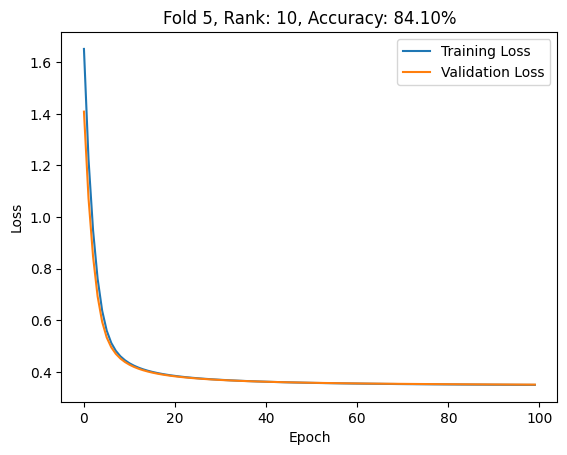


 Rank: 20 computation started for Fold 5

Epoch [1/100], Loss: 2.1906, Validation Loss: 1.8894
Epoch [2/100], Loss: 1.6221, Validation Loss: 1.4116
Epoch [3/100], Loss: 1.2115, Validation Loss: 1.0680
Epoch [4/100], Loss: 0.9305, Validation Loss: 0.8442
Epoch [5/100], Loss: 0.7554, Validation Loss: 0.7075
Epoch [6/100], Loss: 0.6487, Validation Loss: 0.6220
Epoch [7/100], Loss: 0.5803, Validation Loss: 0.5651
Epoch [8/100], Loss: 0.5340, Validation Loss: 0.5253
Epoch [9/100], Loss: 0.5010, Validation Loss: 0.4962
Epoch [10/100], Loss: 0.4765, Validation Loss: 0.4740
Epoch [11/100], Loss: 0.4577, Validation Loss: 0.4567
Epoch [12/100], Loss: 0.4428, Validation Loss: 0.4428
Epoch [13/100], Loss: 0.4308, Validation Loss: 0.4315
Epoch [14/100], Loss: 0.4210, Validation Loss: 0.4222
Epoch [15/100], Loss: 0.4128, Validation Loss: 0.4143
Epoch [16/100], Loss: 0.4058, Validation Loss: 0.4076
Epoch [17/100], Loss: 0.3999, Validation Loss: 0.4018
Epoch [18/100], Loss: 0.3947, Validation Loss: 0

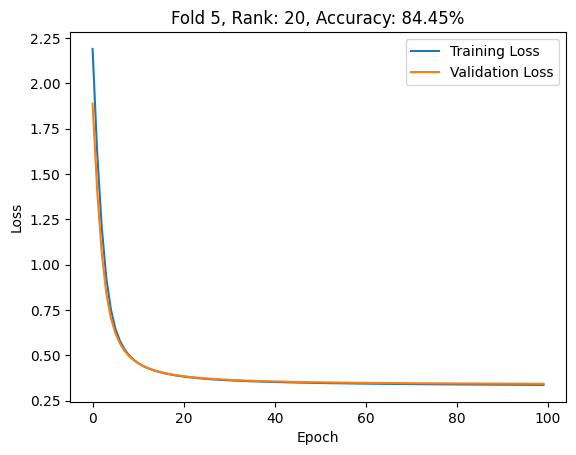


 Rank: 30 computation started for Fold 5

Epoch [1/100], Loss: 2.6825, Validation Loss: 2.2697
Epoch [2/100], Loss: 1.9638, Validation Loss: 1.6675
Epoch [3/100], Loss: 1.4395, Validation Loss: 1.2464
Epoch [4/100], Loss: 1.0962, Validation Loss: 0.9870
Epoch [5/100], Loss: 0.8914, Validation Loss: 0.8328
Epoch [6/100], Loss: 0.7672, Validation Loss: 0.7353
Epoch [7/100], Loss: 0.6856, Validation Loss: 0.6684
Epoch [8/100], Loss: 0.6276, Validation Loss: 0.6191
Epoch [9/100], Loss: 0.5840, Validation Loss: 0.5810
Epoch [10/100], Loss: 0.5499, Validation Loss: 0.5506
Epoch [11/100], Loss: 0.5225, Validation Loss: 0.5257
Epoch [12/100], Loss: 0.4999, Validation Loss: 0.5050
Epoch [13/100], Loss: 0.4811, Validation Loss: 0.4874
Epoch [14/100], Loss: 0.4651, Validation Loss: 0.4725
Epoch [15/100], Loss: 0.4514, Validation Loss: 0.4596
Epoch [16/100], Loss: 0.4397, Validation Loss: 0.4484
Epoch [17/100], Loss: 0.4295, Validation Loss: 0.4386
Epoch [18/100], Loss: 0.4206, Validation Loss: 0

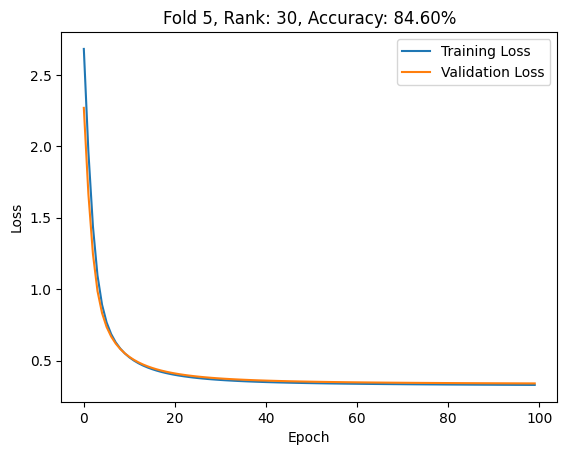


 Rank: 50 computation started for Fold 5

Epoch [1/100], Loss: 3.5350, Validation Loss: 3.0109
Epoch [2/100], Loss: 2.5074, Validation Loss: 2.1264
Epoch [3/100], Loss: 1.7737, Validation Loss: 1.5407
Epoch [4/100], Loss: 1.3276, Validation Loss: 1.2092
Epoch [5/100], Loss: 1.0775, Validation Loss: 1.0204
Epoch [6/100], Loss: 0.9283, Validation Loss: 0.9012
Epoch [7/100], Loss: 0.8293, Validation Loss: 0.8180
Epoch [8/100], Loss: 0.7572, Validation Loss: 0.7557
Epoch [9/100], Loss: 0.7018, Validation Loss: 0.7068
Epoch [10/100], Loss: 0.6573, Validation Loss: 0.6669
Epoch [11/100], Loss: 0.6207, Validation Loss: 0.6338
Epoch [12/100], Loss: 0.5901, Validation Loss: 0.6058
Epoch [13/100], Loss: 0.5638, Validation Loss: 0.5817
Epoch [14/100], Loss: 0.5411, Validation Loss: 0.5608
Epoch [15/100], Loss: 0.5214, Validation Loss: 0.5425
Epoch [16/100], Loss: 0.5042, Validation Loss: 0.5263
Epoch [17/100], Loss: 0.4889, Validation Loss: 0.5120
Epoch [18/100], Loss: 0.4753, Validation Loss: 0

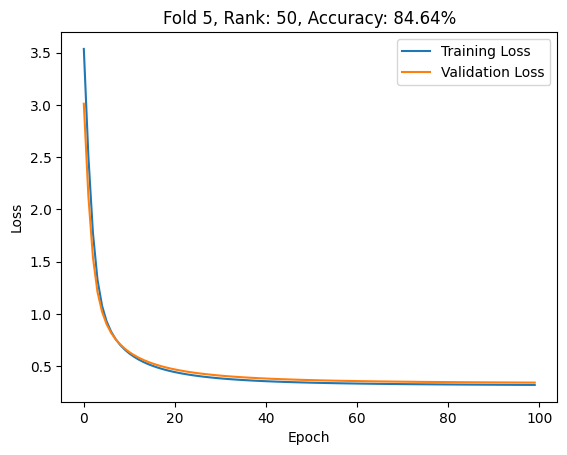


 Rank: 75 computation started for Fold 5

Epoch [1/100], Loss: 4.2556, Validation Loss: 3.5818
Epoch [2/100], Loss: 2.9772, Validation Loss: 2.5090
Epoch [3/100], Loss: 2.0953, Validation Loss: 1.8345
Epoch [4/100], Loss: 1.5752, Validation Loss: 1.4495
Epoch [5/100], Loss: 1.2759, Validation Loss: 1.2196
Epoch [6/100], Loss: 1.0896, Validation Loss: 1.0683
Epoch [7/100], Loss: 0.9627, Validation Loss: 0.9606
Epoch [8/100], Loss: 0.8696, Validation Loss: 0.8792
Epoch [9/100], Loss: 0.7978, Validation Loss: 0.8150
Epoch [10/100], Loss: 0.7401, Validation Loss: 0.7629
Epoch [11/100], Loss: 0.6928, Validation Loss: 0.7195
Epoch [12/100], Loss: 0.6531, Validation Loss: 0.6830
Epoch [13/100], Loss: 0.6197, Validation Loss: 0.6517
Epoch [14/100], Loss: 0.5905, Validation Loss: 0.6246
Epoch [15/100], Loss: 0.5654, Validation Loss: 0.6009
Epoch [16/100], Loss: 0.5434, Validation Loss: 0.5801
Epoch [17/100], Loss: 0.5240, Validation Loss: 0.5616
Epoch [18/100], Loss: 0.5069, Validation Loss: 0

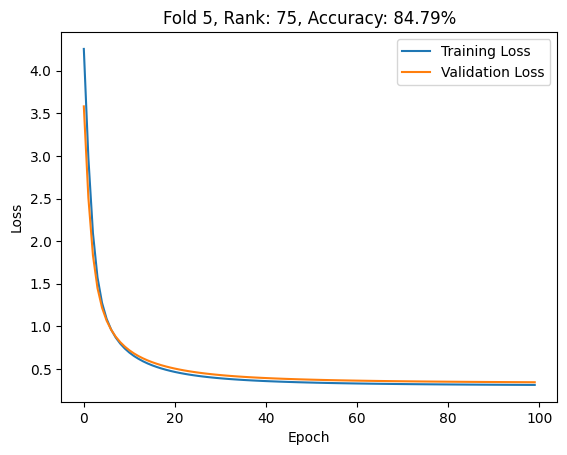


 Rank: 100 computation started for Fold 5

Epoch [1/100], Loss: 4.7379, Validation Loss: 3.9224
Epoch [2/100], Loss: 3.2359, Validation Loss: 2.6724
Epoch [3/100], Loss: 2.2264, Validation Loss: 1.9328
Epoch [4/100], Loss: 1.6667, Validation Loss: 1.5323
Epoch [5/100], Loss: 1.3541, Validation Loss: 1.2943
Epoch [6/100], Loss: 1.1568, Validation Loss: 1.1351
Epoch [7/100], Loss: 1.0190, Validation Loss: 1.0184
Epoch [8/100], Loss: 0.9151, Validation Loss: 0.9280
Epoch [9/100], Loss: 0.8337, Validation Loss: 0.8559
Epoch [10/100], Loss: 0.7682, Validation Loss: 0.7968
Epoch [11/100], Loss: 0.7142, Validation Loss: 0.7476
Epoch [12/100], Loss: 0.6691, Validation Loss: 0.7056
Epoch [13/100], Loss: 0.6306, Validation Loss: 0.6695
Epoch [14/100], Loss: 0.5974, Validation Loss: 0.6381
Epoch [15/100], Loss: 0.5687, Validation Loss: 0.6106
Epoch [16/100], Loss: 0.5437, Validation Loss: 0.5863
Epoch [17/100], Loss: 0.5217, Validation Loss: 0.5648
Epoch [18/100], Loss: 0.5022, Validation Loss: 

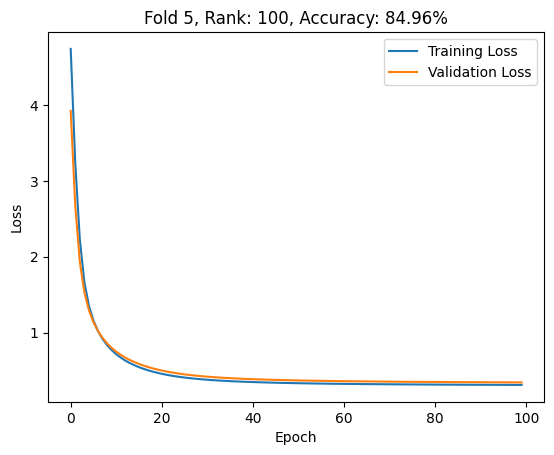

IndexError: list index out of range

In [13]:
accuracies = []
k = 5  # Number of folds
kfold = KFold(n_splits=k, shuffle=True)
n = num_items
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for logistic regression
num_epochs = 100
ranks = [2, 5, 10, 20, 30, 50, 75, 100]
# Loop over the k-fold splits
for fold, (train_index, test_index) in enumerate(kfold.split(dataset)):
    print(f"\nFold {fold + 1}/{k}")
    
    # Creating train and test subsets
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)
    
    # DataLoaders for train and test datasets
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Loop over different ranks
    fold_accuracies = []
    for rank in ranks:
        model = LowRankComparisonModel(n=num_items, r=rank)
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        print(f'\n Rank: {rank} computation started for Fold {fold + 1}\n')
        train_losses, valid_losses = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)
        accuracy = compute_accuracy(model, test_loader)  # Accuracy is better calculated on the test set
        
        # Plotting training and validation loss
        plt.plot(train_losses, label='Training Loss')
        plt.plot(valid_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1}, Rank: {rank}, Accuracy: {accuracy:.2f}%')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        fold_accuracies.append(accuracy)
    
    accuracies.append(fold_accuracies)

# Aggregate accuracy across folds for each rank
mean_accuracies = [sum(fold_accuracies[i] for fold_accuracies in accuracies) / k for i in range(10)]

# Plot Accuracy vs Rank
plt.plot(ranks, mean_accuracies)
plt.title('Accuracy vs Rank (Averaged Across Folds)')
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.show()


In [18]:
accuracies = np.array(accuracies)

In [21]:
np.mean(accuracies, axis=0)

array([80.84842787, 83.16909895, 83.85300817, 84.20021517, 84.44289325,
       84.39561761, 84.5258864 , 84.73179386])

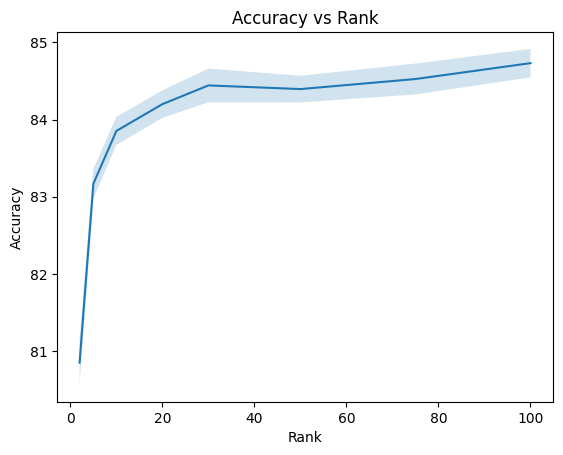

In [20]:
plt.plot(ranks, np.mean(accuracies, axis=0))
plt.title('Accuracy vs Rank')
plt.xlabel('Rank')
plt.ylabel('Accuracy')
# fill in the standard deviation
plt.fill_between(ranks, np.mean(accuracies, axis=0) - np.std(accuracies, axis=0), np.mean(accuracies, axis=0) + np.std(accuracies, axis=0), alpha=0.2)